In [2]:
# data wrangling
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# other
import time

# sklearn
from sklearn.model_selection import train_test_split

# local files
from sofascores import compute_sofa

# 1. Load Data

If you put the data set in the same folder as this notebook, you can use the following code to load the data set. 

In [3]:
# load data
DATA_FILEPATH = "all_hourly_data.h5"
patients = pd.read_hdf(DATA_FILEPATH, "patients")
vitals_labs_mean = pd.read_hdf(DATA_FILEPATH, "vitals_labs_mean")
interventions = pd.read_hdf(DATA_FILEPATH, "interventions")

FileNotFoundError: File all_hourly_data.h5 does not exist

The H5 file contains several tables:
* *patients*: static demographics (gender, ethnicity, age, etc.) and static outcomes (diagnosis, mortality, length-ofstay, etc.)
* *vitals_labs*: time-varying vitals and labs (including the hourly mean, count and standard deviation)
* *vitals_labs_mean*: time-varying vitals and labs (hourly mean only)
* *interventions*: hourly binary indicators for administered interventions

### Patients

The *patients* table contains demographic data, details regarding their hospital stay, outcomes, and a code status.

In [3]:
patients.head()

,,,gender,ethnicity,age,insurance,admittime,diagnosis_at_admission,dischtime,discharge_location,fullcode_first,dnr_first,...,outtime,los_icu,admission_type,first_careunit,mort_icu,mort_hosp,hospital_expire_flag,hospstay_seq,readmission_30,max_hours
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,,,,
3,145834,211552,M,WHITE,76.526792,Medicare,2101-10-20 19:08:00,HYPOTENSION,2101-10-31 13:58:00,SNF,1.0,0.0,...,2101-10-26 20:43:09,6.064560,EMERGENCY,MICU,0,0,0,1,0,145
4,185777,294638,F,WHITE,47.845047,Private,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-23 18:41:00,HOME WITH HOME IV PROVIDR,1.0,0.0,...,2191-03-17 16:46:31,1.678472,EMERGENCY,MICU,0,0,0,1,0,40
6,107064,228232,F,WHITE,65.942297,Medicare,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,2175-06-15 16:00:00,HOME HEALTH CARE,1.0,0.0,...,2175-06-03 13:39:54,3.672917,ELECTIVE,SICU,0,0,0,1,0,88
9,150750,220597,M,UNKNOWN/NOT SPECIFIED,41.790228,Medicaid,2149-11-09 13:06:00,HEMORRHAGIC CVA,2149-11-14 10:15:00,DEAD/EXPIRED,1.0,0.0,...,2149-11-14 20:52:14,5.323056,EMERGENCY,MICU,1,1,1,1,0,127
11,194540,229441,F,WHITE,50.148295,Private,2178-04-16 06:18:00,BRAIN MASS,2178-05-11 19:00:00,HOME HEALTH CARE,1.0,0.0,...,2178-04-17 20:21:05,1.584410,EMERGENCY,SICU,0,0,0,1,0,38


#### Demographics 
* *gender* - genotypical sex of the patient (F for XX and Y for XY);
* *ethnicity* - a simplified version of the US census race/ethnicity categorization;
* *age* - age of the patient at time of admission (**note that the age of patients older than 89 have been replaced by some value >300 for de-identification purposes**)
* *insurance* - insurance type (Medicare, Private, Medicaid, Government, Self Pay). *Medicare is an insurance program that primarily serves older people (>65) as well as younger disabled people and dialysis patients. Medicaid is an insurance program that serves low-income people of every age.*

#### Hospital Stay Details
All [dates in the dataset have been shifted](https://mimic.physionet.org/mimicdata/time/) to protect patient confidentiality.

* *admittime* - time of admission
* *diagnosis_at_admission* - the diagnosis at admission as used for [billing the patient](https://mimic.physionet.org/mimictables/diagnoses_icd/) (*note that this is a proxy for the actual diagnosis*)
* *dischtime* - time of discharge
* *discharge_location* - where the patient went after discharge
* *deathtime* - time of death
* *intime* - ICU admission time
* *outtime* - ICU discharge time
* *admission_type* - type of hospital admission
* *first_careunit* - the first intensive care unit the patient was admitted to: Coronary Care Unit (CCU), Cardiac and Stroke Receiving Unit (CSRU), Mobile Intensive Care Unit (MICU),  Surgical Intensive Care Unit (SICU), or Trauma Surgical Intensive Care Unit (TSICU)
* *hospstay_seq* - indicates whether this is the first, second, third etc. visit. As this dataset considers patient's  first ICU visit only, it is a constant.
* *max_hours* - number of hours (approximately) the patient stayed in the ICU


#### Outcomes
* *los_icu* - length of stay in the ICU
* *mort_icu* - indicates whether the patient died at the ICU (1 if *deathtime* between *intime* and *outtime*)
* *mort_hosp* - indicates whether the patient died at the hospital (1 if *deathtime* between *admittime* and *dischtime*)
* *hospital_expire_flag* - 1 indicates death in the hospital, and 0 indicates survival to hospital discharge
* *readmission_30* - boolean that indicates whether the patient was readmitted within 30 days after discharge

#### Code Status
At some point during their stay, patient's might be asked to select a preferred "code status", which indicates whether you would like to receive live-saving measures or not. The pre-processed data set contains info on three different code statuses. *full code* indicates that the patient would like to receive live-saving measures (such as chest compressions). *do not resuscitate* indicates do not resuscitate, but okay to intubate

* *fullcode_first* - the patient's first code status is "Full code" 
* *dnr_first* - the patient's first registered code status is "Do Not Resuscitate"
* *cmo_first* - the patient's first registered code status is "Comfort Measures Only"
* *fullcode* - the patient's chart contains at least one codestatus equal to "full code"
* *cmo* - the patient's chart contains at least one codestatus equal to "Comfort Measures Only"
* *dnr* - the patient's chart contains at least one codestatus equal to "Do Not Resuscitate"
* *dnr_first_charttime* - the charttime of the patient's first registered "Do Not Resuscitate" status
* *cmo_last* - the patient's last registered code status is "Comfort Measures Only"

## Vitals
The *vitals_labs_mean* table contains lab measurements of 104 different types of vitals, aggregated as the hourly mean for each hour of the patient's stay in the ICU.

* Lab measurements are typically infrequent and as a result the time series is **very sparse**. To obtain a denser representation that is easier to reason about and readily applied to modern machine learning methods for time-series that expect discretized time representations, **observations from each ICU stay’s time-series are aggregated into hourly buckets**.
* In the MIMIC-extract data set, vitals are grouped based on clinical domain expertise (i.e., some pre-processing has already occured for these features)


In [4]:
vitals_labs_mean.head()

LEVEL2                                 alanine aminotransferase albumin  \
Aggregation Function                                       mean    mean   
subject_id hadm_id icustay_id hours_in                                    
3          145834  211552     0                            25.0     1.8   
                              1                             NaN     NaN   
                              2                             NaN     NaN   
                              3                             NaN     NaN   
                              4                             NaN     NaN   

LEVEL2                                 albumin ascites albumin pleural  \
Aggregation Function                              mean            mean   
subject_id hadm_id icustay_id hours_in                                   
3          145834  211552     0                    NaN             NaN   
                              1                    NaN             NaN   
                              2                    NaN             NaN   
                              3                    NaN             NaN   
                              4                    NaN             NaN   

LEVEL2                                 albumin urine alkaline phosphate  \
Aggregation Function                            mean               mean   
subject_id hadm_id icustay_id hours_in                                    
3          145834  211552     0                  NaN               73.0   
                              1                  NaN                NaN   
                              2                  NaN                NaN   
                              3                  NaN                NaN   
                              4                  NaN                NaN   

LEVEL2                                  anion gap asparate aminotransferase  \
Aggregation Function                         mean                      mean   
subject_id hadm_id icustay_id hours_in                                        
3          145834  211552     0         20.666667                      69.0   
                              1               NaN                       NaN   
                              2               NaN                       NaN   
                              3               NaN                       NaN   
                              4               NaN                       NaN   

LEVEL2                                 basophils bicarbonate  ...  \
Aggregation Function                        mean        mean  ...   
subject_id hadm_id icustay_id hours_in                        ...   
3          145834  211552     0              NaN   16.333333  ...   
                              1              NaN         NaN  ...   
                              2              NaN         NaN  ...   
                              3              NaN         NaN  ...   
                              4              NaN         NaN  ...   

LEVEL2                                 total protein total protein urine  \
Aggregation Function                            mean                mean   
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0                  NaN                 NaN   
                              1                  NaN                 NaN   
                              2                  NaN                 NaN   
                              3                  NaN                 NaN   
                              4                  NaN                 NaN   

LEVEL2                                 troponin-i troponin-t venous pvo2  \
Aggregation Function                         mean       mean        mean   
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0               NaN        NaN         NaN   
                              1               NaN        NaN         NaN   
                              

## Interventions

The interventions table contains the administered interventions, aggregated as binary variables for each hour of the patient's stay in the ICU. 

In [5]:
interventions.head()

vent  vaso  adenosine  dobutamine  \
subject_id hadm_id icustay_id hours_in                                      
3          145834  211552     0            1     0          0           0   
                              1            1     1          0           0   
                              2            1     1          0           0   
                              3            1     1          0           0   
                              4            1     1          0           0   

                                        dopamine  epinephrine  isuprel  \
subject_id hadm_id icustay_id hours_in                                   
3          145834  211552     0                0            0        0   
                              1                1            0        0   
                              2                1            0        0   
                              3                0            0        0   
                              4                0            0        0   

                                        milrinone  norepinephrine  \
subject_id hadm_id icustay_id hours_in                              
3          145834  211552     0                 0               0   
                              1                 0               0   
                              2                 0               0   
                              3                 0               0   
                              4                 0               1   

                                        phenylephrine  vasopressin  \
subject_id hadm_id icustay_id hours_in                               
3          145834  211552     0                     0            0   
                              1                     1            0   
                              2                     1            0   
                              3                     1            0   
                              4                     1            0   

                                        colloid_bolus  crystalloid_bolus  \
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0                     0                  0   
                              1                     0                  0   
                              2                     0                  0   
                              3                     0                  0   
                              4                     0                  0   

                                        nivdurations  
subject_id hadm_id icustay_id hours_in                
3          145834  211552     0                    0  
                              1                    0  
                              2                    0  
                              3                    0  
                              4                    0

# 2. Basic Pre-Processing
There are many different ways in which an ICU mortality prediction task can be formulated. **For this assignment, we advise you to use a static approach and predict whether a patient will die, given the first 24 hours of their stay.**

### Example Pre-Processing
To help you get started, we have prepared several pre-processing steps:
1. Merge the `vitals_labs_mean` and `intervention` tables.
2. Split the dataset into training, validation, and test set.
3. Forward fill missing values: if a measurement was done at a certain time for a particular patient, this measurement is forward filled in time until a new measurement was taken.
4. Remove variables with more than 80% missing values across all hours after forward filling.
5. Impute remaining missing values with the mean of the original data for each variable across all hours (before forward filling)
6. Add demographics table

### Further Pre-Processing
The current pre-processing procedure is just an example and you are free to adapt or add to it as much as you like. Some ideas:
* The number of features is very high. You may consider reducing the number of features e.g., through feature selection or aggregating across hourly measurements.
* You need to decide whether you want to include the demographics as features in your machine learning model, or only use them for evaluation.
* Some machine learning models, such as logistic regression and support vector machines, can benefit from normalization.

#### Tips
* To avoid information leakage, any pre-processing steps must be based on the **training data only**. For example, when we compute the mean, this must be computed based on the training data set.
* The dataset contains hourly measurements of a set of variables. It is likely more informative to compute the average and standard deviation based on the raw measurements across all hours (i.e., `X.stack()`, as opposed to the imputed dataset.).
* The resulting dataset is a multi-index dataframe. When you use this directly in scikit-learn 1.0 or higher, you will get a warning `FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple'].`. This warning can be easily silenced by converting your dataframe into a numpy array before passing it to the model (`numpy.array(X)`) or by flattening the multi-index columns into strings. 

**In your report, make sure to motivate all pre-processing steps.**

In [6]:
"""
Task Formulation: predict whether a patient will die, given the first 24 hours of their stay
"""

# SETTINGS
window_size = 24  # the first WINDOW_SIZE hours of the patient's stay
gap_time = 6  # the number of hours the patient lived at least after the first WINDOW_SIZE hours (to avoid label leakage, see MIMIC-III Extract paper)
test_size = 0.2  # proportion of the data that wil lbe used for testing
val_size = 0.125  # proportion of the training data that will be used for validation
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values after forward fill for a measurement to be dropped

In [7]:
start_time = time.time()

"""PREPARE VITALS LABES AND INTERVENTIONS"""
# get target variable (died in ICU) of patients that stayed at least GAP_TIME + WINDOW_SIZE hours in the ICU
y = patients[patients.max_hours > window_size + gap_time]["mort_icu"]

# select first 24 hours of patient data for ICU stays of selected patients
X = vitals_labs_mean.droplevel(
    level="Aggregation Function", axis=1
).copy()  # drop constant 'mean' level
X = X.join(interventions)  # add interventions
X = X[
    (
        X.index.get_level_values("icustay_id").isin(
            set(y.index.get_level_values("icustay_id"))
        )
    )
    & (X.index.get_level_values("hours_in") < window_size)
]

# reset index so only subject_id is in index
y = y.reset_index(level=["hadm_id", "icustay_id"], drop=True)
X = X.reset_index(level=["hadm_id", "icustay_id"], drop=True).unstack()


"""SPLIT DATA"""
# define train/test split based on index
X_train_r, X_test_r, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)
X_train_r, X_val_r, y_train, y_val = train_test_split(
    X_train_r, y_train, test_size=val_size, random_state=random_state
)

"""IMPUTE MISSING VALUES"""
# compute mean and std of raw values
mean = X_train_r.stack().mean(axis=0)
std = X_train_r.stack().std(axis=0)

# forward fill missing values
X_train = X_train_r.copy().stack(dropna=False).groupby("subject_id").ffill()
X_test = X_test_r.copy().stack(dropna=False).groupby("subject_id").ffill()
X_val = X_val_r.copy().stack(dropna=False).groupby("subject_id").ffill()

# remove features with too many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

# impute remaining missing values with the mean of original data and get to hourly
means = X_train_r.stack().mean(
    axis=0
)  # get average of hourly measurement value for each feature
X_train = X_train.fillna(means).unstack()
X_test = X_test.fillna(means).unstack()
X_val = X_val.fillna(means).unstack()

"""ADD DEMOGRAPHICS"""
# convert gender to boolean feature
demo = pd.get_dummies(patients[["gender"]], drop_first=True)

# replace age of people older than 89 by 90
demo["age"] = patients["age"]
demo.loc[demo[demo["age"] >= 90].index, "age"] = 90

# create ethnicity columns
demo["white"] = patients["ethnicity"].str.contains("WHITE")
demo["black"] = patients["ethnicity"].str.contains("BLACK")
demo["asian"] = patients["ethnicity"].str.contains("ASIAN")
demo["hispanic"] = patients["ethnicity"].str.contains("HISPANIC")
demo["other/unknown"] = ~(
    demo["white"] | demo["black"] | demo["asian"] | demo["hispanic"]
)

# reset index to remove icu id and hadm id
demo = demo.reset_index(level=[1, 2], drop=True)
demo.columns = pd.MultiIndex.from_product([demo.columns, [-1]])

# add demographics to dataframes
X_train = X_train.join(demo)
X_val = X_val.join(demo)
X_test = X_test.join(demo)

"""RESET INDEX"""
y_train = y_train.reindex(X_train.index)
y_test = y_test.reindex(X_test.index)
y_val = y_val.reindex(X_val.index)

"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

Time: 26.02s
Train set: 16760 rows, 1903 columns
Validation set: 2395 rows, 1903 columns
Test set: 4789 rows, 1903 columns


# 3. Compute SOFA scores
The SOFA (Sequential Organ Failure Assessment) score is a tool that is currently used in ICU's to judge the likelihood of mortality. The SOFA score is computed as a score of 0 to 4 for six different systems (the cardiovescular system, coagulation, kidney, liver, nervous system, respiratory system), which totals to a maximum score of 24.

A high total SOFA score and a high delta SOFA (the total maximum SOFA minus the admission total SOFA) have been shown to be related to a worse outcome and the total score has been shown to increase over time in nonsurvivors compared with survivors.

## Compute SOFA
You can compute the scores for the six categories for patients in the data set using `compute_sofa()`, with the following parameters:
* `X` : the data set with at least the following features: ['systolic blood pressure', 'diastolic blood pressure', 'platelets', 'creatinine', 'bilirubin', 'glascow coma scale total', 'partial pressure of oxygen', 'vent'] for different times.
* `time` : the timestamp for which SOFA is to be computed.

**Important Notes**
* In theory, the SOFA scores can vary from 0 to 24. The MIMIC Extract dataset does not contain all data needed to compute the SOFA score. In particular, it is missing dosage information of catecholamines. As such, **the SOFA scores computed by `compute_sofa()` should be interpreted as a lower bound of the actual SOFA score!**
* In practice, ICU  will likely have requested the measurements whenever they want to compute the SOFA score. In our case, the required measurements may not have always been available. Although we have filled missing values using a reasonable approach, this may reduce the predictive performance of SOFA scores compared to practice.

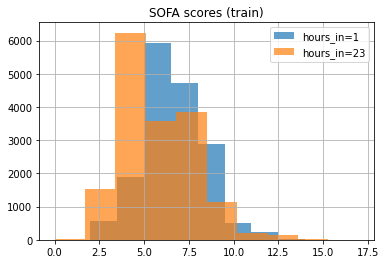

In [8]:
# compute sofa scores
sofa_scores_at1 = compute_sofa(X=X_train, time=1)
sofa_scores_at23 = compute_sofa(X=X_train, time=23)

# retrieve sum for all systems to combine as a final score
y_sofa_at1 = pd.DataFrame(sofa_scores_at1).sum(axis=1)
y_sofa_at23 = pd.DataFrame(sofa_scores_at23).sum(axis=1)

y_sofa_at1.hist(label="hours_in=1", alpha=0.7)
y_sofa_at23.hist(label="hours_in=23", alpha=0.7)
plt.title("SOFA scores (train)")
plt.legend()
plt.show()